# Data Visualization Notebook

## Objectives

* Answer business requirement no.1:
    - The client is interested in carrying out a study that focuses on visually distinguishing between a healthy cherry leaf and one that shows signs of powdery mildew.

## Inputs

Images are taken from the test, train, validation folders and their subfolders.

    ├── inputs
    │   └──cherryleaves_dataset 
    │      └──cherry-leaves
    │           │
    │           ├── test
    │           │   ├── healthy
    │           │   └── powdery_mildew
    │           │
    │           ├── train
    │           │   ├── healthy
    │           │   └── powdery_mildew
    │           │
    │           └── validation
    │               ├── healthy
    │               └── powdery_mildew
    └──

## Outputs

* Compute the average image size from the training set.
    - Since the CNN will be trained on the test set, it is essential to standardize all input images to the same size. The chosen input size will directly determine the CNN architecture.

* Leverage the saved image shape embeddings (pickle file).
    - Use these embeddings to analyze image dimensions and ensure consistency.

* Visualize image characteristics by label.
    - Plot the mean and variability of image sizes for each class label.

* Highlight class-specific differences.
    - Create plots that emphasize the contrast between healthy cherry leaves and those infected with mildew.

* Address Business Requirement 1.
    - Develop code that not only fulfills this requirement but can also be adapted to generate an image montage for display in the Streamlit dashboard.

## Comments | Insights | Conclusions

These steps are necessary to further understand and prepare the data that will be fed into the CNN. Additionally, the data has been visually arranged to meet the client’s request (Business Requirement #1)

---

# Import libraries

In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import joblib
sns.set_style('white')
from matplotlib.image import imread

# Set working directory

In [2]:
cwd= os.getcwd()

In [4]:
os.chdir('/workspaces/Cherry-Powdery-Mildew-Detector')
print("You set a new current directory")

You set a new current directory


In [5]:
work_dir = os.getcwd()
work_dir

'/workspaces/Cherry-Powdery-Mildew-Detector'

# Set input directories

Set train, validation and test paths

In [6]:
my_data_dir = 'inputs/cherryleaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train' 
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

# Set output directory

In [7]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

# Set label names

In [8]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


---

# Data visualization of image data

## Compute average images size on train set

In computer vision, it’s common practice to normalize image pixel values using the dataset’s mean and standard deviation. This improves consistency when applying a model to new images and is especially useful for transfer learning. However, computing these statistics can be tricky in practice, since the entire dataset often can’t be loaded into memory at once and must instead be processed in batches.

This answers Business Requirement #1

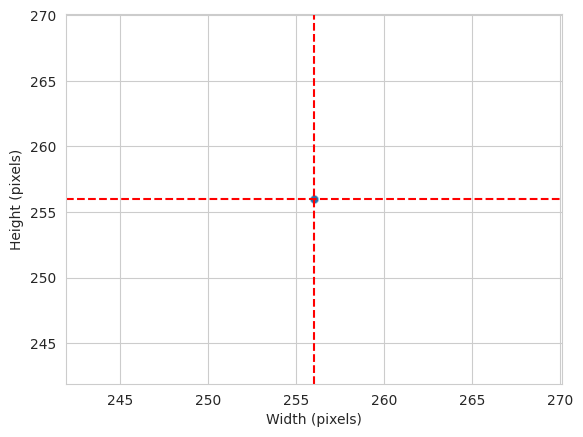

Width average: 256 
Height average: 256


In [9]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_path + '/' + label):
        img = imread(train_path + '/' + label + '/' + image_filename)
        d1, d2, colors = img.shape
        dim1.append(d1)  # image height
        dim2.append(d2)  # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

## Images size for training the model is the average from all images in the train set.

In [10]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(256, 256, 3)

## Save the image shape embeddings

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

# Average and variability of images per label

## Function to load images in an array (tensor)

In [19]:
from keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

## Load image shapes and labels in an array

In [21]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 256, 256, 3) (60,)


## Plot and save mean and variability of images per label

In [22]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (256, 256, 3)
==== Label powdery_mildew ====
Image Shape: (256, 256, 3)


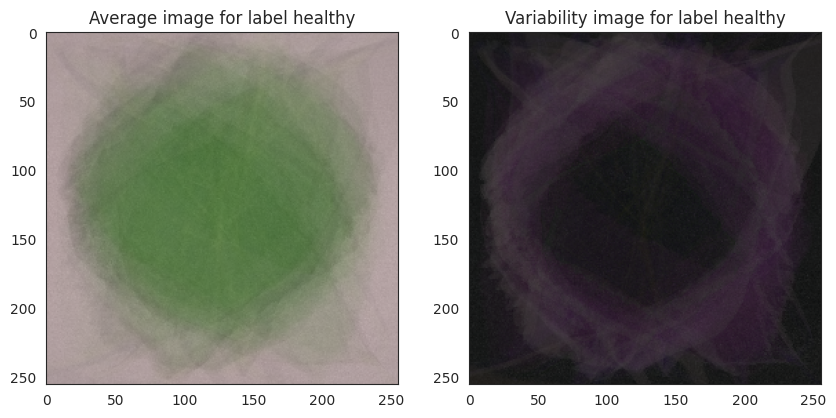

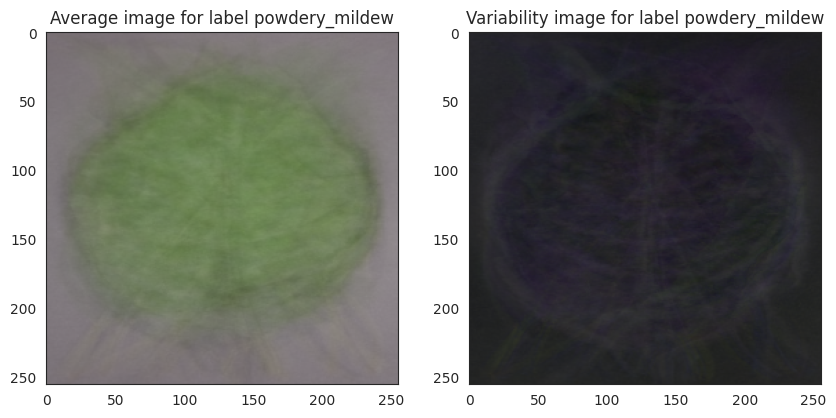

In [23]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)

---